In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from firedrake import *
import numpy as np
from functions import fcs as fcs

In [2]:
t = 0
reduce = 1.
t_end = 3/reduce
n = 512
d_t = (t_end-t)/(154./reduce)
a = t
b = t + d_t
M = 2 # number of GL nodes
dt = Constant(d_t)
mesh = PeriodicIntervalMesh(n,1) # create periodic grid
x = SpatialCoordinate(mesh)[0]  # extract coordinates
c_s = Constant(1)               # speed of sound
U = Constant(0.05)              # mean flow

VV = FunctionSpace(mesh,'Lagrange',1) # function space. Functions will be approximated using second order Lagrange Polynomials
V = VV*VV                              # Create mixed functions space. Need to use due to coupled system
U_0 = Function(V)
U_n1 = Function(V)                   # Vector containing Solutions at t+1
U_n = Function(V)                    # Vector containing Solutions at t

XX = Function(V)
X = XX.vector()

U_n1_o= Function(V)                    # Vector containing solutions at previous iterations
U_n_o = Function(V)
Resi= Function(V)
#residual_u, residual_p = Resi.split()
u_n, p_n = U_n.split() #important! don't use split(U_n) but how is this related to wence warning? See: https://github.com/firedrakeproject/firedrake/issues/1819
u_n1,p_n1=U_n1.split()
v = TestFunction(V)   

#c_s = 0.2
#U = 0.1
x1 = 0.25
x0 = 0.75
sigma = 0.1
k = 7.2*np.pi
#S = np.asmatrix([[1,1],[1,-1]])
#S_1 = np.asmatrix([[0.5,0.5],[0.5,-0.5]])
#A = np.asmatrix([[U,c_s],[c_s,U]])

# SDC Parameters
iterations = 2
M = 2

def p0(x,sigma=sigma):
    return exp(-x**2/sigma**2)
                 
def p1 (x,p0=p0,sigma=sigma,k=k):
    return p0(x)*cos(k*x/sigma)

def p(x,p0=p0,p1=p1,x0=x0,x1=x1,coeff=1.):
    return p0(x-x0) + coeff*p1(x-x1)


def pp0(x,sigma=sigma):
    return np.exp(-x**2/sigma**2)
                 
def pp1 (x,p0=pp0,sigma=sigma,k=k):
    return p0(x)*np.cos(k*x/sigma)

xx = np.linspace(0,1,n) # fem nodes

p_init = p(x)   # Initial Conditions
#p_init = np.exp(-(xx-0.5)**2/sigma**2) # arbitrary initial data without UFL
U_n.sub(1).interpolate(p_init)
#p_n.interpolate(p_init)            # set initial conditions to U_n
#u_n, p_n = split(U_n)
# p_n(xx) or any list instead of xx to evaluate p_n at coordinates xx

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x117f5ca90>, FiniteElement('Lagrange', interval, 1), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1), 4)), 25)

<IPython.core.display.Javascript object>


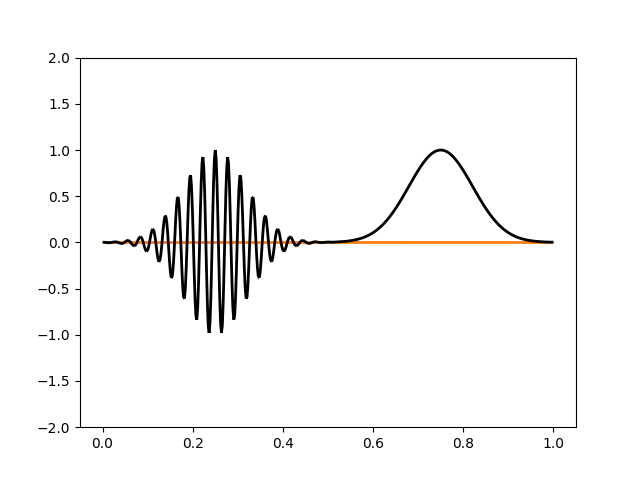

/Users/jf/Firedrake/firedrake/src/firedrake/firedrake/plot.py:805: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)


In [3]:
# check if initial conditions actually got applied
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_ylim((-2., 2.))
plot(u_n, axes=axes, color='C1')
plot(p_n, axes=axes)

In [4]:
# fast part of rhs, to be integrated implicitly 
def ff(U_n,c_s):
    u_n, p_n = split(U_n) #splitting somehow only needed for implicit solution !!! compare to U_n.split() !!!
    return as_vector([c_s*p_n.dx(0),c_s*u_n.dx(0)])

# slow part of rhs, to be integrated explicitly
def fs(U_n,U):
    u_n, p_n = split(U_n) #splitting somehow only needed for implicit solution
    return as_vector([U*u_n.dx(0),U*p_n.dx(0)])

def right_hand_side(U_n,U_n1,ff=ff,fs=fs,U=U,c_s=c_s):
    return -ff(U_n1,c_s) - fs(U_n,U)

f_fast = ff(U_n1,c_s)
f_slow = fs(U_n,U)

In [5]:
# set up simple IMEX
F = (inner((U_n1 - U_n)/dt,v) + inner(f_fast,v) + inner(f_slow,v))*dx

In [6]:
problem = NonlinearVariationalProblem(F, U_n1)
solver = NonlinearVariationalSolver(problem,nest=False, solver_parameters={'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu'})#{"ksp_type": "preonly", "pc_type": "ilu"})

# results stores every timestep
results = [Function(U_n)]

In [7]:
# try to integrate
dts = np.zeros(M)

# initialize lists that store temporary data
rhs = ['-']*M
temp= ['-']*M
u_temp = ['-']*M
p_temp = ['-']*M
residuals = ['-']*M
U_0.assign(U_n)
# time integration loop
while t <= t_end:
    a = t
    b = t + d_t
    nodes, weights = fcs.GL(M,a,b)
    Q = fcs.Qmatrix(nodes,t,fcs.my_get_weights)
    S = fcs.Smatrix(Q)
    #Q = as_matrix(Q) # create ufl tensor
    S = as_matrix(S) # create ufl tensor
    dts[0] = nodes[0]-t
    dts[1:]= nodes[1:]-nodes[0:-1]
    U_n_old = [Function(U_n)]    
    # calculate initial trajectory
    for i in range(0,M):
        dt.assign(dts[i])
        solver.solve() #this updates U_n1 
        U_n.assign(U_n1) # initial trajectory is DONE here
        U_n_old.append(Function(U_n)) # store initial trajectory

    for k in range(0,iterations): 
        # calculate rhs for calculating S@u_nm and S@p_nm later       
        for i in range(0,M):
            temp[i]   = right_hand_side(U_n_old[i+1],U_n_old[i+1]) # temp
            u_nm,p_nm = temp[i]
            u_temp[i] = u_nm
            p_temp[i] = p_nm
        u_nm = as_vector(u_temp)
        p_nm = as_vector(p_temp)
        residual_u = dot(S,u_nm)
        residual_p = dot(S,p_nm)   
        
        # now do actual SDC iteration:
        U_n.assign(U_0)  # set U_n to be the solution at t=a
        U_n_new = [Function(U_n)]   # create storage for k+1 iteration
        for i in range(0,M):
            dt.assign(dts[i])
            X = as_vector([residual_u[i],residual_p[i]])
            # this needs to be done with assign, but I dont know how to do it because listtensor object has no attriute assign...
            # seems to be a waste of ressources to define the problem within every iteration
            F_SDC = (inner((U_n1 - U_n - dt*(right_hand_side(U_n,U_n1)-right_hand_side(U_n_old[i],U_n_old[i+1])) - X),v)) * dx
            problem_SDC = NonlinearVariationalProblem(F_SDC, U_n1)
            SDC_solver = NonlinearVariationalSolver(problem_SDC,nest=False, solver_parameters={'mat_type': 'aij',
                'ksp_type': 'preonly',
                'pc_type': 'lu'})
            SDC_solver.solve()
            U_n.assign(U_n1)
            U_n_new.append(Function(U_n))
        U_n_old = U_n_new
          
    # final update:
    # TODO: implement quadrature
    U_n_new = U_n_new[1:]
    W = as_vector(weights)
    for i in range(0,M):
        u , p = right_hand_side(U_n_new[i],U_n_new[i])
        u_temp[i] = u
        p_temp[i] = p
    u_nm = as_vector(u_temp)
    p_nm = as_vector(p_temp)
    u_new = dot(u_nm,W)
    p_new = dot(p_nm,W)
    U_n.assign(project(U_0 + as_vector([u_new,p_new]),V))
    results.append(Function(U_n))
    U_0.assign(U_n)
    t += d_t

<IPython.core.display.Javascript object>


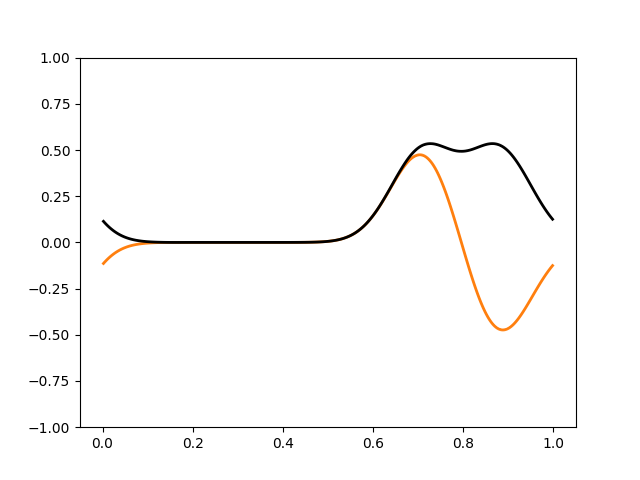

/Users/jf/Firedrake/firedrake/src/firedrake/firedrake/plot.py:805: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)


In [8]:
fig, axes = plt.subplots()
axes.set_ylim((-1., 1.))
plot(u_n, axes=axes, color='C1')
plot(p_n, axes=axes)

In [9]:
# NBVAL_IGNORE_OUTPUT

from matplotlib.animation import FuncAnimation
tt = np.arange(0,t_end+d_t,d_t)
def animate(U_n):
    u_n, p_n = U_n.split()
    axes.clear()
    firedrake.plot(u_n, axes=axes,color='C1')
    firedrake.plot(p_n, axes=axes)
    axes.set_ylim((-1., 1.))
    #axes.annotate('t: %.2f' % t,xy=(0.1,0.1))

interval = 5e4 * float(d_t)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())


/Users/jf/Firedrake/firedrake/src/firedrake/firedrake/plot.py:805: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)


In [ ]:
U_n.assign(U_0)
increment = project(U_0 + as_vector([u_new,p_new]),V)
fig1, axes1 = plt.subplots()
#axes1.set_ylim((-2., 2.))
plot(U_0.sub(0), axes=axes1, color='C1',lw=1)
plot(U_0.sub(1), axes=axes1,lw=1)
plot(increment.sub(0),axes=axes1,lw=1,linestyle='--',color='C2')
plot(increment.sub(1),axes=axes1,lw =1,linestyle='--',color='C3')

def u_exact(t,mesh=xx,cs=1,):
    """
    Routine to compute the exact solution at time t
    Args:
        t (float): current time
    Returns:
        dtype_u: exact solution STOLEN from pySDC
    """
    sigma_0 = 0.1
    k = 7.0 * 2.0 * np.pi
    x_0 = 0.75
    x_1 = 0.25

    ms = 1.0

    me = np.zeros(len(mesh))
    me[:] = np.exp(-np.square(mesh - x_0 - cs * t) / (sigma_0 * sigma_0)) + \
        ms * np.exp(-np.square(mesh - x_1 - cs * t) / (sigma_0 * sigma_0)) * \
        np.cos(k * (mesh - cs * t) / sigma_0)
    return me
    
exact_0 = u_exact(0)
exact_1 = u_exact(1)
fig1, axes1 = plt.subplots()
axes1.plot(xx,exact_0)
#axes1.plot(xx,exact_1)
axes1.plot(xx,p0)
axes1.plot(xx,test1)